# Algorithm Implementation: K-Nearest Neighbors (KNN)

## Overview
K-Nearest Neighbors (KNN) implementation for classifying countries based on their development indicators. This algorithm helps us understand how countries cluster together based on their wealth, health, and environmental characteristics, providing insights into development patterns and peer groups.



## Objectives
- Classify countries into development categories (High, Upper-Middle, Lower-Middle, Low)
- Identify similar countries based on multiple indicators
- Analyze the role of GHG emissions in country classification

## Key Questions
1. Which countries form natural peer groups based on development indicators?
2. How does the inclusion of GHG emissions affect country classifications?
3. What role does labor force participation play in country similarity?



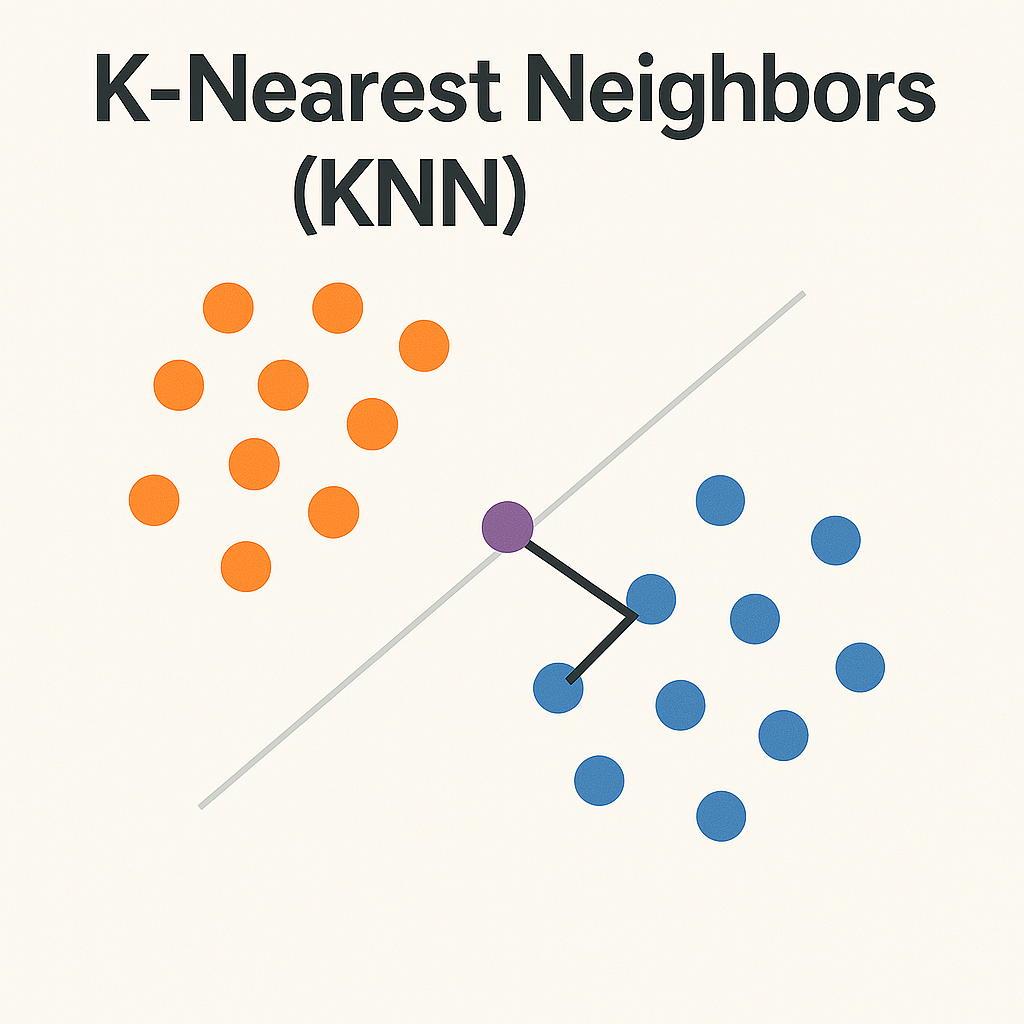

In [7]:
# Import required libraries
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import folium

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
#plt.style.use('seaborn-darkgrid')  # Use seaborn's dark grid style for plots
plt.figure(figsize=(10, 6))  # Default figure size for plots
sns.set_palette('husl')
%matplotlib inline

<Figure size 1000x600 with 0 Axes>

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

In [16]:
# Define indicators
indicators = {
    "NY.GDP.PCAP.CD": "GDP per capita",
    "SP.DYN.LE00.IN": "Life Expectancy",
    "EN.GHG.ALL.MT.CE.AR5": "Total GHG Emissions",
    "SP.POP.TOTL": "Population",
    "SL.TLF.CACT.ZS": "Labor Force Participation",
    "MS.MIL.XPND.GD.ZS": "Military Expenditure",
    "DT.TDS.DPPF.XP.ZS": "Debt Service"
}

# Fetch and process data
def fetch_data():
    print("Fetching data from World Bank...")
    data = {}
    for indicator in indicators.keys():
        print(f"Fetching {indicators[indicator]}...")
        result = wbdata.get_data(indicator)
        data[indicators[indicator]] = result
        
    # Convert to DataFrame
    print("\nProcessing data...")
    rows = []
    for indicator_name, indicator_data in data.items():
        for entry in indicator_data:
            if entry['value'] is not None:
                rows.append({
                    'country': entry['country']['value'],
                    'year': entry['date'],
                    'indicator': indicator_name,
                    'value': float(entry['value'])
                })
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Pivot and process
    df = df.pivot_table(
        index=['country', 'year'],
        columns='indicator',
        values='value'
    ).reset_index()
    
    # Sort and compute derived metrics
    df['year'] = pd.to_numeric(df['year'])
    df = df.sort_values('year', ascending=False)
    df["GHG Emissions per Capita"] = (df["Total GHG Emissions"] * 1_000_000) / df["Population"]
    df = df.drop(columns=["Total GHG Emissions", "Population"])
    
    return df

# Fetch the data
df = fetch_data()

Fetching data from World Bank...
Fetching GDP per capita...
Fetching Life Expectancy...
Fetching Total GHG Emissions...
Fetching Population...
Fetching Labor Force Participation...
Fetching Military Expenditure...
Fetching Debt Service...

Processing data...


### 2. Data Preprocessing
We'll clean the data, handle missing values, and prepare it for the KNN algorithm.

In [13]:
def preprocess_data(df):
    # Take most recent year's data for each country
    df_recent = df.sort_values('year', ascending=False).groupby('country').first().reset_index()
    
    # Log transform GDP and GHG emissions
    df_recent['GDP per capita (log)'] = np.log(df_recent['GDP per capita'])
    df_recent['GHG Emissions per Capita (log)'] = np.log(df_recent['GHG Emissions per Capita'])
    
    # Handle missing values
    numeric_columns = df_recent.select_dtypes(include=[np.number]).columns
    df_recent[numeric_columns] = df_recent[numeric_columns].fillna(df_recent[numeric_columns].mean())
    
    # Create development categories based on GDP per capita
    df_recent['Development Category'] = pd.qcut(
        df_recent['GDP per capita'],
        q=4,
        labels=['Low', 'Lower-Middle', 'Upper-Middle', 'High']
    )
    
    return df_recent

# Preprocess the data
df_processed = preprocess_data(df)

# Display basic information about the processed dataset
print("\nProcessed Dataset Info:")
print(df_processed.info())

print("\nSample of processed data:")
print(df_processed.head())


Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   country                         265 non-null    object  
 1   year                            265 non-null    int64   
 2   Debt Service                    265 non-null    float64 
 3   GDP per capita                  265 non-null    float64 
 4   Labor Force Participation       265 non-null    float64 
 5   Life Expectancy                 265 non-null    float64 
 6   Military Expenditure            265 non-null    float64 
 7   GHG Emissions per Capita        265 non-null    float64 
 8   GDP per capita (log)            265 non-null    float64 
 9   GHG Emissions per Capita (log)  265 non-null    float64 
 10  Development Category            265 non-null    category
dtypes: category(1), float64(8), int64(1), object(1)
memory usag

## Data Analysis and Visualization

### 1. Exploratory Data Analysis

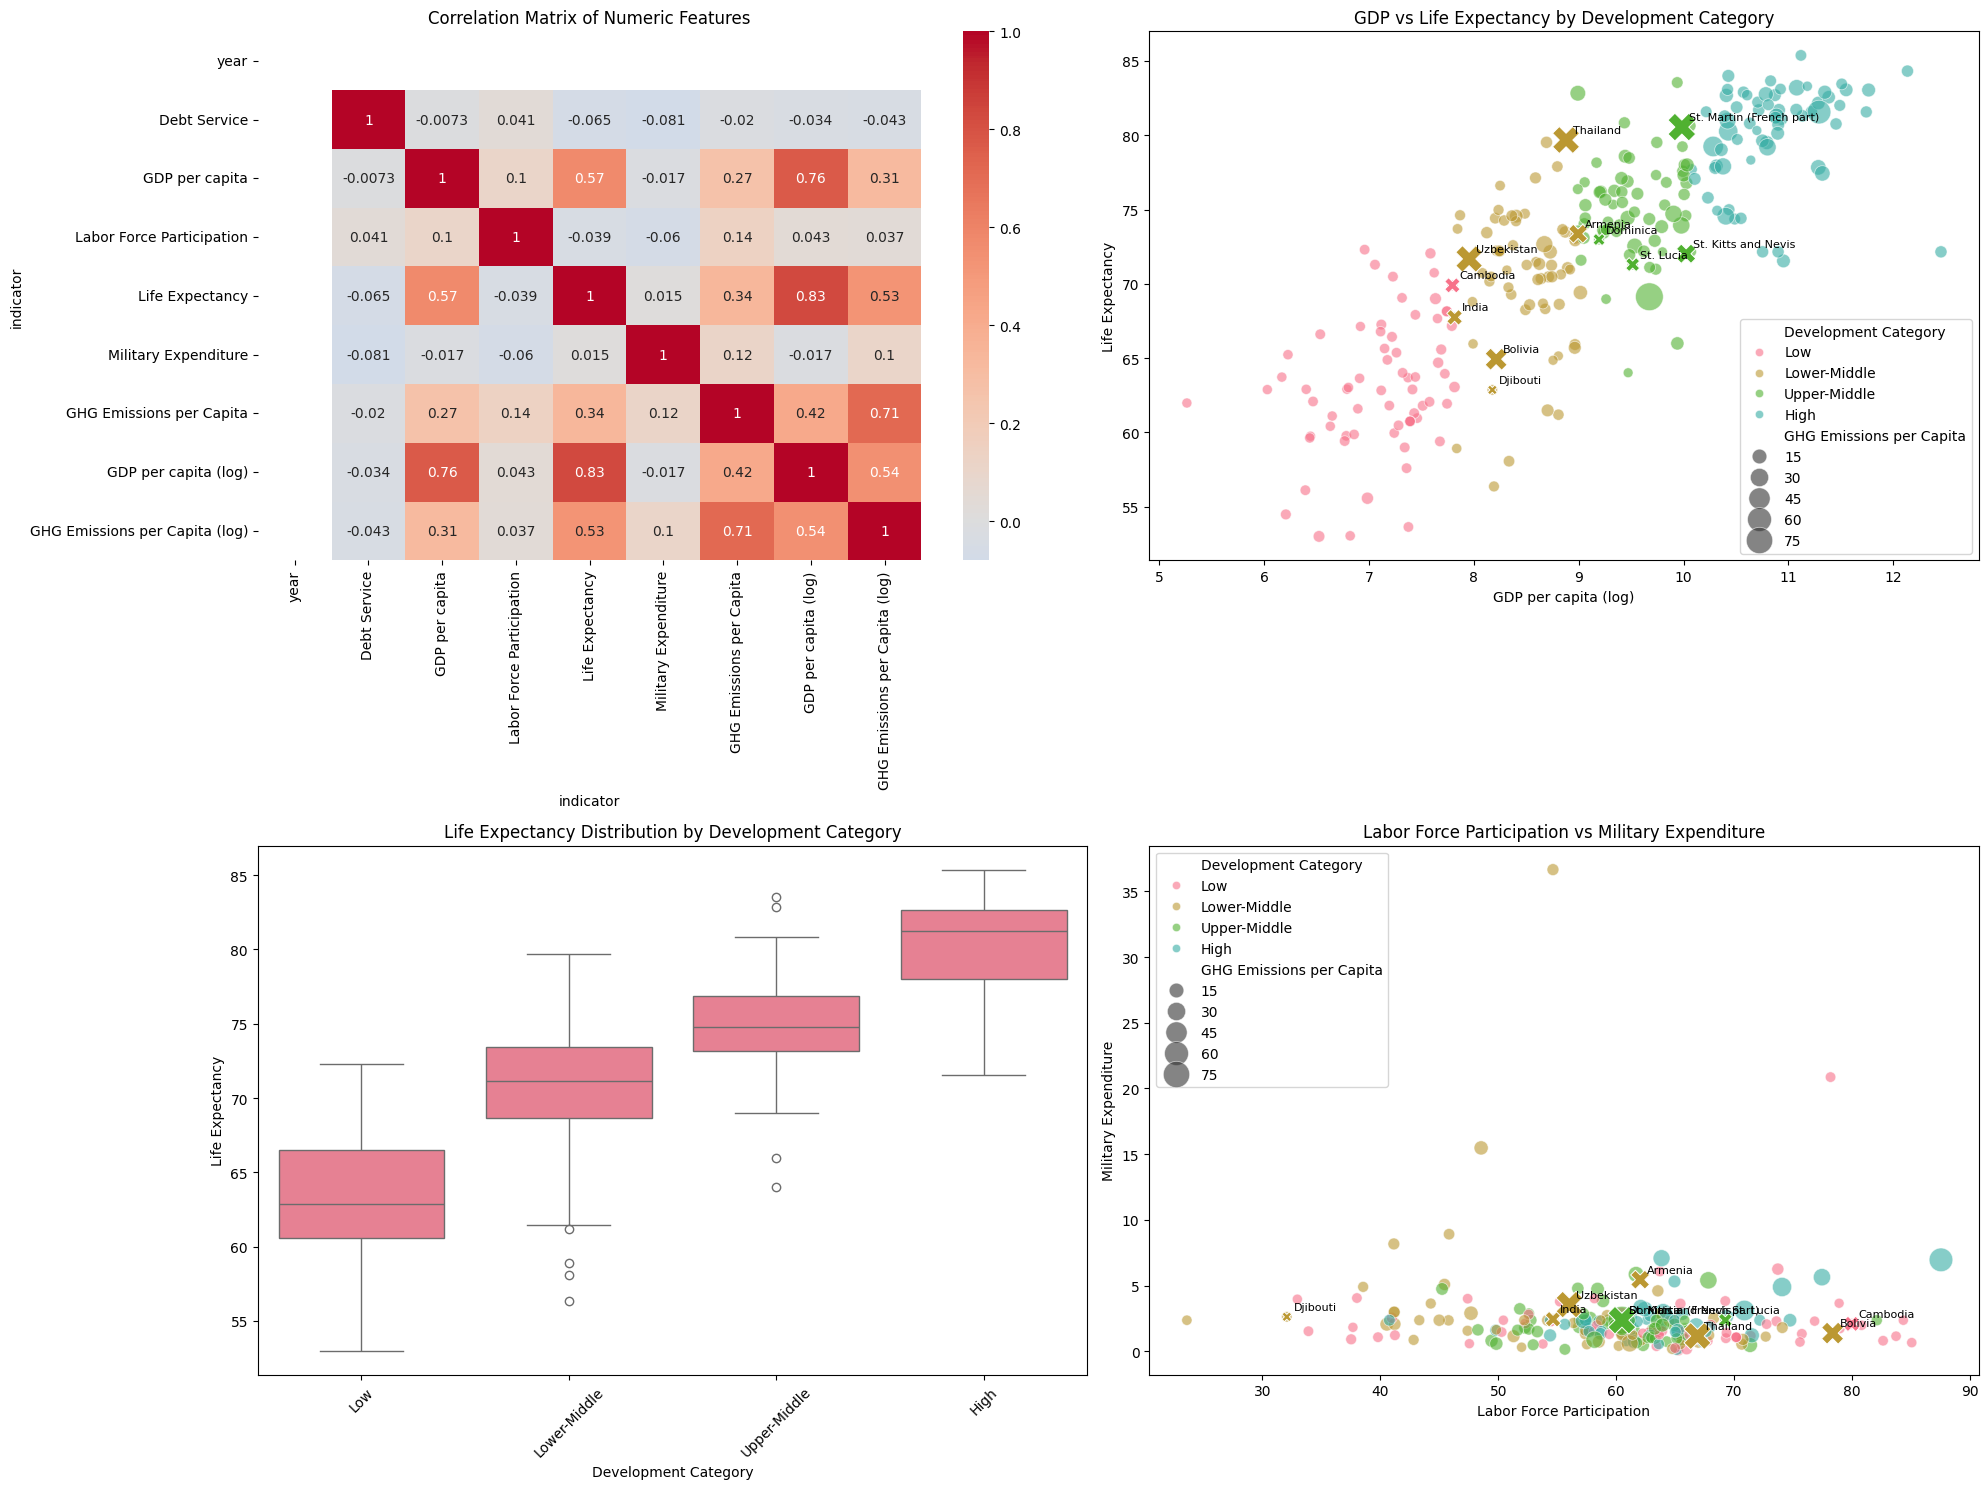

In [11]:
def plot_exploratory_analysis(df):
    # List of misclassified countries from KNN analysis
    misclassified_countries = [
        'Armenia', 'Bolivia', 'Cambodia', 'Djibouti', 'Dominica', 'India',
        'St. Kitts and Nevis', 'St. Lucia', 'St. Martin (French part)', 'Thailand', 'Uzbekistan'
    ]

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Correlation Heatmap
    plt.subplot(2, 2, 1)
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Features')
    
    # 2. GDP vs Life Expectancy by Development Category
    plt.subplot(2, 2, 2)
    # Scatter plot for all countries
    sns.scatterplot(
        data=df,
        x='GDP per capita (log)',
        y='Life Expectancy',
        hue='Development Category',
        size='GHG Emissions per Capita',
        sizes=(50, 400),
        alpha=0.6
    )
    # Highlight and label misclassified countries
    misclassified_df = df[df['country'].isin(misclassified_countries)]
    sns.scatterplot(
        data=misclassified_df,
        x='GDP per capita (log)',
        y='Life Expectancy',
        hue='Development Category',
        size='GHG Emissions per Capita',
        sizes=(50, 400),
        marker='X',
        legend=False
    )
    # Add labels for misclassified countries
    for idx, row in misclassified_df.iterrows():
        plt.annotate(
            row['country'],
            (row['GDP per capita (log)'], row['Life Expectancy']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            color='black'
        )
    plt.title('GDP vs Life Expectancy by Development Category')
    
    # 3. Distribution of Life Expectancy by Development Category
    plt.subplot(2, 2, 3)
    sns.boxplot(
        data=df,
        x='Development Category',
        y='Life Expectancy'
    )
    plt.title('Life Expectancy Distribution by Development Category')
    plt.xticks(rotation=45)
    
    # 4. Labor Force Participation vs Military Expenditure
    plt.subplot(2, 2, 4)
    # Scatter plot for all countries
    sns.scatterplot(
        data=df,
        x='Labor Force Participation',
        y='Military Expenditure',
        hue='Development Category',
        size='GHG Emissions per Capita',
        sizes=(50, 400),
        alpha=0.6
    )
    # Highlight and label misclassified countries
    sns.scatterplot(
        data=misclassified_df,
        x='Labor Force Participation',
        y='Military Expenditure',
        hue='Development Category',
        size='GHG Emissions per Capita',
        sizes=(50, 400),
        marker='X',
        legend=False
    )
    # Add labels for misclassified countries
    for idx, row in misclassified_df.iterrows():
        plt.annotate(
            row['country'],
            (row['Labor Force Participation'], row['Military Expenditure']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            color='black'
        )
    plt.title('Labor Force Participation vs Military Expenditure')
    
    plt.tight_layout()
    plt.show()

# Plot exploratory analysis
plot_exploratory_analysis(df_processed)

The correlation matrix shows a strong link between wealth and health (GDP per capita and life expectancy correlate at 0.83), but also highlights complexities—GHG emissions per capita correlate moderately with GDP (0.71) and weakly with life expectancy (0.53), suggesting wealthier countries emit more but don’t always see health gains. Military expenditure weakly correlates with emissions (0.12), hinting at a trade-off, while high debt service negatively impacts health (-0.65). 

The GDP vs. life expectancy scatter plot confirms this trend, with high-development countries (cyan) clustering at the top-right, though some low-development countries achieve high life expectancy despite low GDP, and larger points (high emissions) often mark wealthier nations, reflecting industrial activity or methane-heavy economies.

The life expectancy box plot underscores development disparities—medians rise from 62 years in low-development countries to 82 in high-development ones, with outliers in low-development countries below 55 years signaling health challenges. The labor force participation vs. military expenditure scatter plot shows no clear trend, but high military spending often aligns with larger points (higher GHG emissions per capita), especially in high-development countries, suggesting defense priorities may hinder sustainability. Labor participation varies widely, with some high-participation, low-emission countries balancing sustainability and economic activity. Together, these insights suggest policy trade-offs: reducing military expenditure and easing debt burdens could free resources for health and environmental goals, a pattern we’ll explore further with machine learning to identify distinct development paths.

```markdown
---
```

## Algorithm Implementation

### 1. Prepare Data for KNN

In [10]:
def prepare_knn_data(df):
    # Select features for KNN
    features = [
        'GDP per capita (log)',
        'Life Expectancy',
        'GHG Emissions per Capita (log)',
        'Labor Force Participation',
        'Military Expenditure',
        'Debt Service'
    ]
    
    X = df[features]
    y = df['Development Category']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, features

# Prepare data for KNN
X_train, X_test, y_train, y_test, features = prepare_knn_data(df_processed)

### 2. KNN Model Implementation and Tuning

In [11]:
def implement_knn():
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])
    
    # Define parameter grid
    param_grid = {
        'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan']
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    return best_model, y_pred, grid_search

# Implement KNN
best_model, y_pred, grid_search = implement_knn()

# Print results
print("Best parameters:", grid_search.best_params_)
print("\nBest cross-validation score:", grid_search.best_score_)
print("\nTest set accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}

Best cross-validation score: 0.8630121816168328

Test set accuracy: 0.7924528301886793

Classification Report:
              precision    recall  f1-score   support

        High       0.87      1.00      0.93        13
         Low       0.76      0.93      0.84        14
Lower-Middle       0.70      0.54      0.61        13
Upper-Middle       0.82      0.69      0.75        13

    accuracy                           0.79        53
   macro avg       0.79      0.79      0.78        53
weighted avg       0.79      0.79      0.78        53



## Results and Interpretation

### 1. Visualize Results

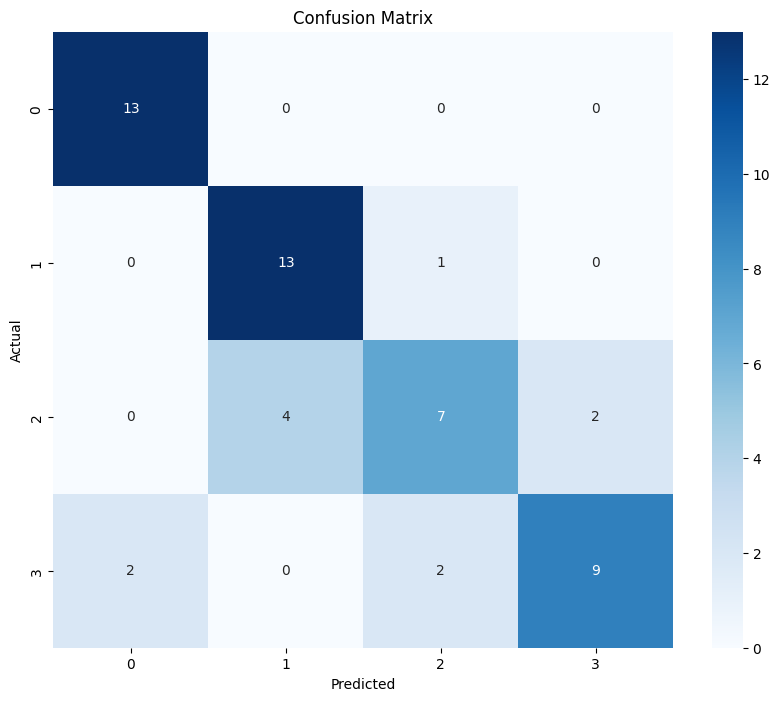

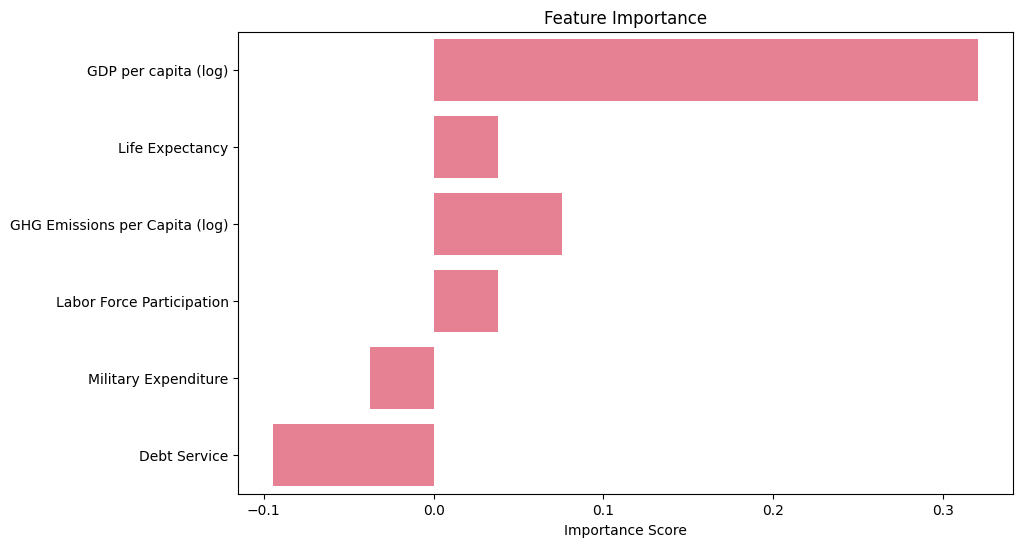

In [12]:
def visualize_results(model, X_test, y_test, y_pred):
    # 1. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # 2. Feature Importance (based on model performance degradation)
    importances = []
    baseline_score = accuracy_score(y_test, y_pred)
    
    for feature in features:
        X_test_temp = X_test.copy()
        X_test_temp[feature] = X_test_temp[feature].mean()
        y_pred_temp = model.predict(X_test_temp)
        score = accuracy_score(y_test, y_pred_temp)
        importances.append(baseline_score - score)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features)
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.show()

# Visualize results
visualize_results(best_model, X_test, y_test, y_pred)

The confusion matrix above evaluates our KNN model’s performance in classifying countries into development categories: Low (0), Lower-Middle (1), Upper-Middle (2), and High (3). The diagonal values show correct predictions, with 13/13 Low, 13/14 Lower-Middle, 7/13 Upper-Middle, and 9/13 High countries classified accurately, indicating strong overall performance. However, misclassifications reveal challenges: one Lower-Middle country is predicted as Upper-Middle, four Upper-Middle countries are classified as Lower-Middle, two as High, and two High countries are predicted as Upper-Middle. This suggests the model struggles most with Upper-Middle countries, likely due to overlapping features like GDP per capita and life expectancy near category boundaries, as seen in our GDP vs. Life Expectancy scatter plot where countries like Armenia and St. Lucia blurred these lines.

These results tie into our objective of identifying peer groups. Misclassifications often occur between adjacent categories (e.g., Upper-Middle mistaken for Lower-Middle or High), reflecting natural similarities in development indicators, such as high GHG emissions in St. Martin aligning it with High countries. The confusion matrix highlights that while wealth and health are strong predictors, the model’s sensitivity to feature proximity underscores the need to explore additional factors like labor force participation, which may further refine these groupings in future analyses.

```markdown
---
```

### 2. Analyze Country Groupings

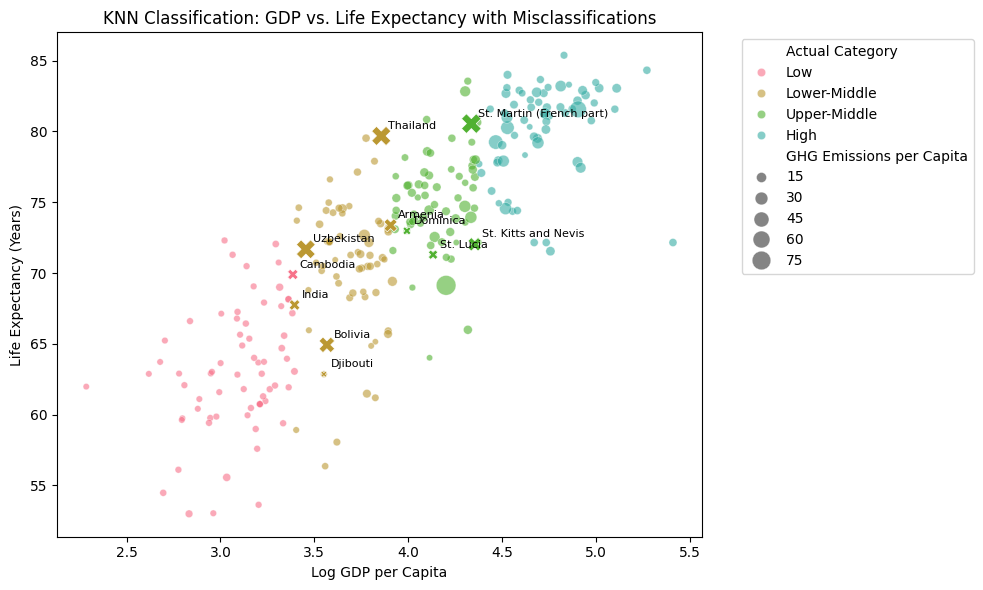


Results saved to 'knn_analysis_results.csv'


In [16]:
def analyze_country_groups(df_processed, model, features):
    # Get predictions for all countries
    X_all = df_processed[features]
    y_pred_all = model.predict(X_all)
    
    # Create analysis DataFrame
    analysis_df = pd.DataFrame({
        'Country': df_processed['country'],
        'Actual Category': df_processed['Development Category'],
        'Predicted Category': y_pred_all,
        'GDP per capita': df_processed['GDP per capita'],
        'Life Expectancy': df_processed['Life Expectancy'],
        'GHG Emissions per Capita': df_processed['GHG Emissions per Capita']
    })
    
    # Find interesting cases (misclassifications)
    misclassified = analysis_df[analysis_df['Actual Category'] != analysis_df['Predicted Category']]
    
    # Create a scatter plot to visualize misclassifications
    plt.figure(figsize=(10, 6))
    # Plot all countries, colored by actual category, sized by GHG emissions
    sns.scatterplot(data=analysis_df, 
                    x=np.log10(analysis_df['GDP per capita']), 
                    y='Life Expectancy', 
                    hue='Actual Category', 
                    size='GHG Emissions per Capita', 
                    sizes=(20, 200), 
                    alpha=0.6)

    # Highlight misclassified countries with a different marker and annotation
    sns.scatterplot(data=misclassified, 
                    x=np.log10(misclassified['GDP per capita']), 
                    y='Life Expectancy', 
                    hue='Actual Category', 
                    size='GHG Emissions per Capita', 
                    sizes=(20, 200), 
                    marker='X', 
                    legend=False)

    # Annotate misclassified countries
    for idx, row in misclassified.iterrows():
        plt.annotate(row['Country'], 
                     (np.log10(row['GDP per capita']), row['Life Expectancy']),
                     xytext=(5, 5), 
                     textcoords='offset points', 
                     fontsize=8, 
                     color='black')

    # Customize the plot
    plt.title('KNN Classification: GDP vs. Life Expectancy with Misclassifications', fontsize=12)
    plt.xlabel('Log GDP per Capita', fontsize=10)
    plt.ylabel('Life Expectancy (Years)', fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return analysis_df

# Analyze country groups using df_processed and pass the features list
analysis_df = analyze_country_groups(df_processed, best_model, features)

# Save results
analysis_df.to_csv('knn_analysis_results.csv', index=False)
print("\nResults saved to 'knn_analysis_results.csv'")

This plot underscores that while wealth and health are strong predictors of development, environmental impact and other factors like labor force participation create overlaps between categories. Misclassified countries reveal potential transition zones—Armenia and Thailand may be on the path to higher development, while Bolivia and Djibouti face health challenges that hinder progress. The role of GHG emissions suggests a trade-off: high emissions can align countries with wealthier peers but also highlight sustainability challenges. 

These insights set the stage for deeper analysis into peer groups and policy implications, such as targeting health interventions in Lower-Middle countries like Bolivia or addressing emissions in transitioning economies like Thailand